In [1]:
import os
import ray
import re
import random
import datetime

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from util_results import *
#from estimator import *
#from evaluator import run_grid_search

os.environ.pop('http_proxy', None)

c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\ray\_private\parameter.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Parse Web of Science data (https://data.mendeley.com/datasets/9rw3vkcfy4/5)

In [2]:
input_file = Path('./data/WOS46985/X.txt')
target_file = Path('./data/WOS46985/YL1.txt')
results_folder = Path('./data/WOS46985_RESULTS')
processed_data_file = Path('./data/WOS46985_RESULTS/data.json')

class_labels = ["Computer Science","Electrical Engineering", "Psychology", "Mechanical Engineering", "Civil Engineering", "Medical Science", "Biochemistry", "N/A"]
class_labels_to_id = {c_name: i for i, c_name in enumerate(class_labels)}
dataset = 'WOS46985'
def parse_WOS46985(input_file, target_file):
    
    data = []

    # Read input sentences
    with open(input_file, 'r') as f_input:
        inputs = f_input.read().splitlines()

    # Read target classes
    with open(target_file, 'r') as f_class:
        classes = f_class.read().splitlines()

    # Ensure the number of inputs and classes match
    if len(inputs) != len(classes):
        raise ValueError("Number of input sentences does not match number of classes")

    # Create list of dictionaries
    for i, (inp, cls) in enumerate(zip(inputs, classes)):
        sample = {
            "id": i + 1, # Using 1-based index for id
            "input": inp,
            "class": class_labels[int(cls)]
        }
        data.append(sample)

    return data


def balance_dataset(class_labels, samples, total_samples):
    # Shuffle the samples
    random.shuffle(samples)
    
    n_samples_per_class = total_samples // len(class_labels)
    balanced_dataset = []
    class_count = {label: 0 for label in class_labels}
    
    remaining_samples = []
    
    for sample in samples:
        label = sample['class']
        if class_count[label] < n_samples_per_class:
            balanced_dataset.append(sample)
            class_count[label] += 1
        else:
            remaining_samples.append(sample)
    
    # If we still need more samples to reach total_samples, randomly sample from remaining samples
    while len(balanced_dataset) < total_samples and remaining_samples:
        random_sample = random.choice(remaining_samples)
        balanced_dataset.append(random_sample)
        remaining_samples.remove(random_sample)

    # Now, extract one sample per class from the remaining samples
    one_sample_per_class = []
    for label in class_labels:
        for s in remaining_samples:
            if s['class'] == label:
                one_sample_per_class.append(s)
                break
                
    return balanced_dataset[:total_samples], one_sample_per_class  # Ensure exactly total_samples in the output


random.seed(42)

n_samples = 2000

if not os.path.exists(processed_data_file):
    data_list, one_shot_examples = balance_dataset(class_labels[:-1], parse_WOS46985(input_file, target_file), n_samples)  # do not count NA

    # Serialize the dictionary to a JSON string
    json_data = json.dumps((data_list, one_shot_examples))
    
    # Write the JSON string to a file
    with open(processed_data_file, 'w') as f:
        f.write(json_data)
else:
    with open(processed_data_file, 'r') as f:
        loaded_data = json.load(f)
    
    # Handle both old format (single list) and new format (tuple of two lists)
    if isinstance(loaded_data, list) and len(loaded_data) == 2:
        # New format: tuple of (data_list, one_shot_examples)
        data_list, one_shot_examples = loaded_data
    elif isinstance(loaded_data, list):
        # Old format: single list containing full dataset, need to re-balance
        data_list, one_shot_examples = balance_dataset(class_labels[:-1], loaded_data, n_samples)
        # Save in new format for future use
        json_data = json.dumps((data_list, one_shot_examples))
        with open(processed_data_file, 'w') as f:
            f.write(json_data)
    else:
        raise ValueError(f"Unexpected data format in {processed_data_file}")

sample_ids = [s["id"] for s in data_list]

def class_extractor_fun(text):
    # we might want to check if more than a word is returned, but does not seem strictly necessary
    for l in class_labels:
        if l.lower() in text.lower():
            return l
    # if no label has been found
    return "N/A"

In [3]:
input_file = Path('./data/WOS46985/X.txt')
target_file = Path('./data/WOS46985/YL1.txt')
results_folder = Path('./data/WOS46985_RESULTS')
processed_data_file = Path('./data/WOS46985_RESULTS/data.json')

class_labels = ["Computer Science","Electrical Engineering", "Psychology", "Mechanical Engineering", "Civil Engineering", "Medical Science", "Biochemistry", "N/A"]
class_labels_to_id = {c_name: i for i, c_name in enumerate(class_labels)}
dataset = 'WOS46985'
def parse_WOS46985(input_file, target_file):
    
    data = []

    # Read input sentences
    with open(input_file, 'r') as f_input:
        inputs = f_input.read().splitlines()

    # Read target classes
    with open(target_file, 'r') as f_class:
        classes = f_class.read().splitlines()

    # Ensure the number of inputs and classes match
    if len(inputs) != len(classes):
        raise ValueError("Number of input sentences does not match number of classes")

    # Create list of dictionaries
    for i, (inp, cls) in enumerate(zip(inputs, classes)):
        sample = {
            "id": i + 1, # Using 1-based index for id
            "input": inp,
            "class": class_labels[int(cls)]
        }
        data.append(sample)

    return data


def balance_dataset(class_labels, samples, total_samples):
    # Shuffle the samples
    random.shuffle(samples)
    
    n_samples_per_class = total_samples // len(class_labels)
    balanced_dataset = []
    class_count = {label: 0 for label in class_labels}
    
    remaining_samples = []
    
    for sample in samples:
        label = sample['class']
        if class_count[label] < n_samples_per_class:
            balanced_dataset.append(sample)
            class_count[label] += 1
        else:
            remaining_samples.append(sample)
    
    # If we still need more samples to reach total_samples, randomly sample from remaining samples
    while len(balanced_dataset) < total_samples and remaining_samples:
        random_sample = random.choice(remaining_samples)
        balanced_dataset.append(random_sample)
        remaining_samples.remove(random_sample)

    # Now, extract one sample per class from the remaining samples
    one_sample_per_class = []
    for label in class_labels:
        for s in remaining_samples:
            if s['class'] == label:
                one_sample_per_class.append(s)
                break
                
    return balanced_dataset[:total_samples], one_sample_per_class  # Ensure exactly total_samples in the output


random.seed(42)

n_samples = 2000
if not os.path.exists(processed_data_file):
    data_list, one_shot_examples = balance_dataset(class_labels[:-1], parse_WOS46985(input_file, target_file), n_samples)  # do not count NA

    # Serialize the dictionary to a JSON string
    json_data = json.dumps((data_list, one_shot_examples))
    
    # Write the JSON string to a file
    with open(processed_data_file, 'w') as f:
        f.write(json_data)
else:
    with open(processed_data_file, 'r') as f:
        loaded_data = json.load(f)
    
    # Handle both old format (single list) and new format (tuple of two lists)
    if isinstance(loaded_data, list) and len(loaded_data) == 2:
        # New format: tuple of (data_list, one_shot_examples)
        data_list, one_shot_examples = loaded_data
    elif isinstance(loaded_data, list):
        # Old format: single list containing full dataset, need to re-balance
        data_list, one_shot_examples = balance_dataset(class_labels[:-1], loaded_data, n_samples)
        # Save in new format for future use
        json_data = json.dumps((data_list, one_shot_examples))
        with open(processed_data_file, 'w') as f:
            f.write(json_data)
    else:
        raise ValueError(f"Unexpected data format in {processed_data_file}")
    
sample_ids = [s["id"] for s in data_list]


def class_extractor_fun(text):
    # we might want to check if more than a word is returned, but does not seem strictly necessary
    for l in class_labels:
        if l.lower() in text.lower():
            return l
    # if no label has been found
    return "N/A"

In [4]:
s_id = 1
print(data_list[s_id]['input'])
print(data_list[s_id]['class'])

for s in one_shot_examples:
    print(s['class'])

Nanoscale spacing between the plasma membrane and the underlying cortical actin cytoskeleton profoundly modulates cellular morphology, mechanics, and function. Measuring this distance has been a key challenge in cell biology. Current methods for dissecting the nanoscale spacing either limit themselves to complex survey design using fixed samples or rely on diffraction-limited fluorescence imaging whose spatial resolution is insufficient to quantify distances on the nanoscale. Using dual-color super-resolution STED (stimulated-emission-depletion) microscopy, we here overcome this challenge and accurately measure the density distribution of the cortical actin cytoskeleton and the distance between the actin cortex and the membrane in live Jurkat T-cells. We found an asymmetric cortical actin density distribution with a mean width of 230 (+105/-125) nm. The spatial distances measured between the maximum density peaks of the cortex and the membrane were bi-modally distributed with mean valu

## Run a grid search over parameters

In [5]:
question_to_rewrite = "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry."

prompt_simple = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, and Biochemistry.\nHere is the text: {summary}"]    
]

prompt_instruct = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: \n- Computer Science: The study of algorithms, data structures, and software design to solve complex problems using computational systems. \n- Electrical Engineering: Focuses on the design, development, and testing of electrical equipment, from microchips to power station generators. \n- Psychology: The scientific study of the mind and behavior, exploring how people think, feel, and interact.\n- Mechanical Engineering: Involves the design, analysis, and manufacturing of mechanical systems, ranging from small components to large machinery.\n- Civil Engineering: Deals with the design, construction, and maintenance of infrastructure projects such as bridges, roads, and buildings.\n- Medical Science: Encompasses the study and research of the human body and its functions, aiming to improve health and treat diseases.\n- Biochemistry: The study of chemical processes within and related to living organisms, merging biology and chemistry to understand cellular and molecular mechanisms.\nHere is the text: {summary}"]    
]

prompt_fewshot = [
    ["system", "You are a text classifier."],
    ["user", "Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, and Biochemistry.\n"]    
]
prompt_fewshot[1][1] = prompt_fewshot[1][1] + "Here are a few examples:\n"
for s in one_shot_examples:
    prompt_fewshot[1][1] = prompt_fewshot[1][1] + f"Class {s['class']}: {s['input']}\n" 
prompt_fewshot[1][1] = prompt_fewshot[1][1] + "\nHere is the text: {summary}"

prompt_types = {"simple": prompt_simple,
                "instruct": prompt_instruct,
                "fewshot": prompt_fewshot,
                }

print(prompt_instruct)

llms = ['llama-3.2-1b']#, 'gpt-3.5', 'gpt-4o']
Qs = [30] # number of equivalent but alternative questions compared to original question
temp_questions = [0.]#list(np.arange(0., 1.25, 0.25))  # temperature of the LLM used to produce questions
# temp_questions = list(np.arange(0., 0.25, 0.25))  # temperature of the LLM used to produce questions
As = [1] # number of alternative answers for each questions
temp_answers =  [0.] # list(np.arange(0., 1.5, 0.25))  # temperature of the LLM used to produce answers

samples = data_list
n_samples = len(samples)
print(f'Num test examples is {len(samples)}')

[['system', 'You are a text classifier.'], ['user', 'Classify the text based on whether their field is Computer Science, Electrical Engineering, Psychology, Mechanical Engineering, Civil Engineering, Medical Science, or Biochemistry.\nAnswer with the class name only.\nThe possible classes are: \n- Computer Science: The study of algorithms, data structures, and software design to solve complex problems using computational systems. \n- Electrical Engineering: Focuses on the design, development, and testing of electrical equipment, from microchips to power station generators. \n- Psychology: The scientific study of the mind and behavior, exploring how people think, feel, and interact.\n- Mechanical Engineering: Involves the design, analysis, and manufacturing of mechanical systems, ranging from small components to large machinery.\n- Civil Engineering: Deals with the design, construction, and maintenance of infrastructure projects such as bridges, roads, and buildings.\n- Medical Science:

Prompt type: simple


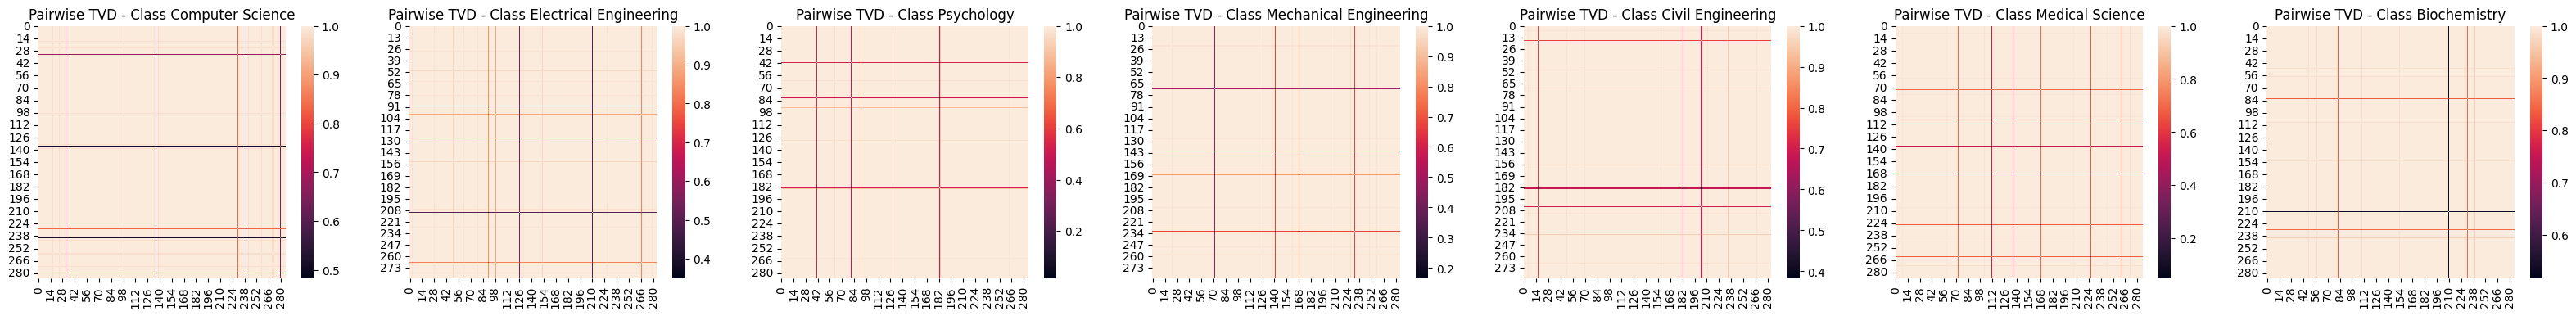

Prompt type: instruct


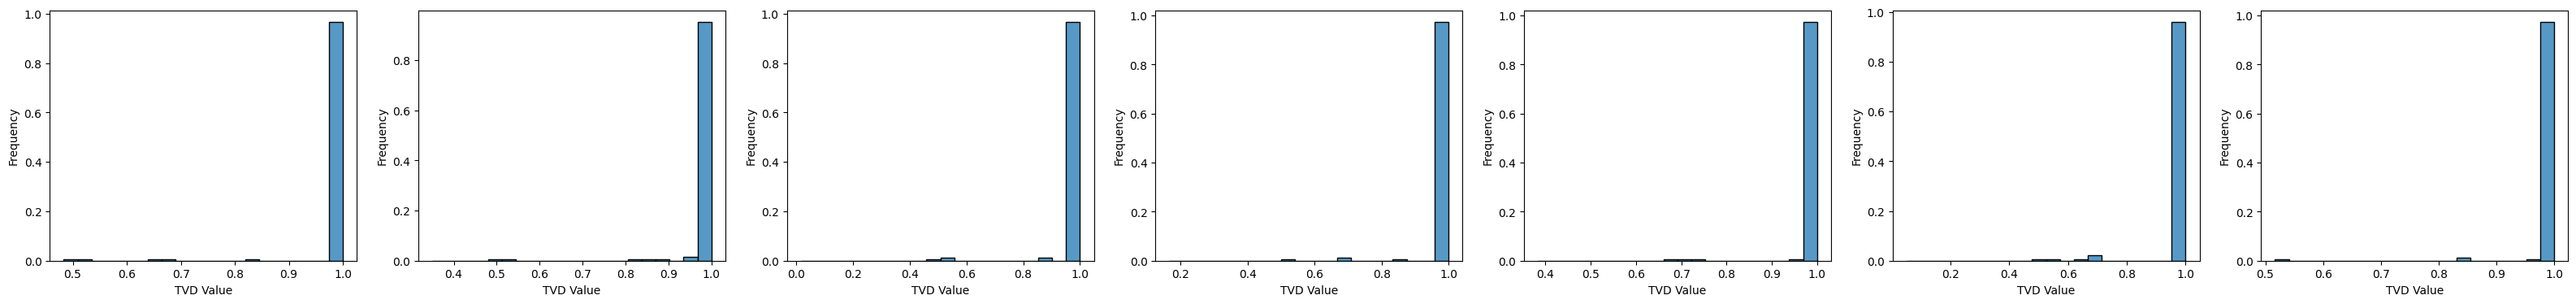

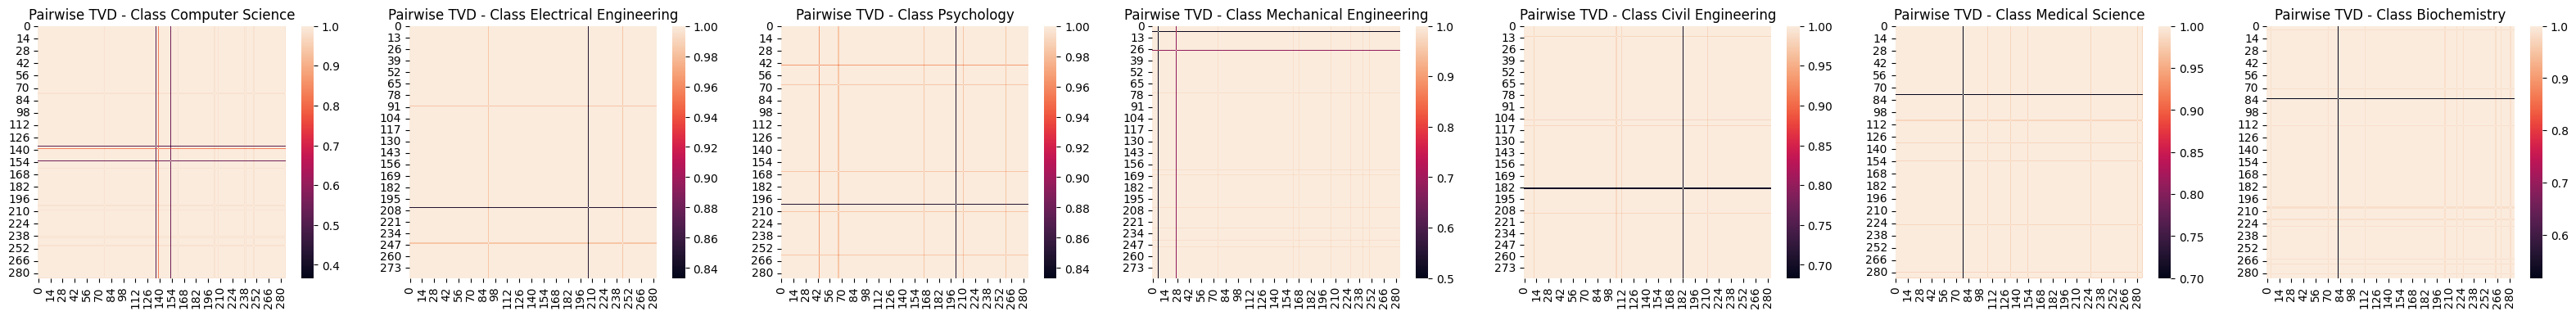

Prompt type: fewshot


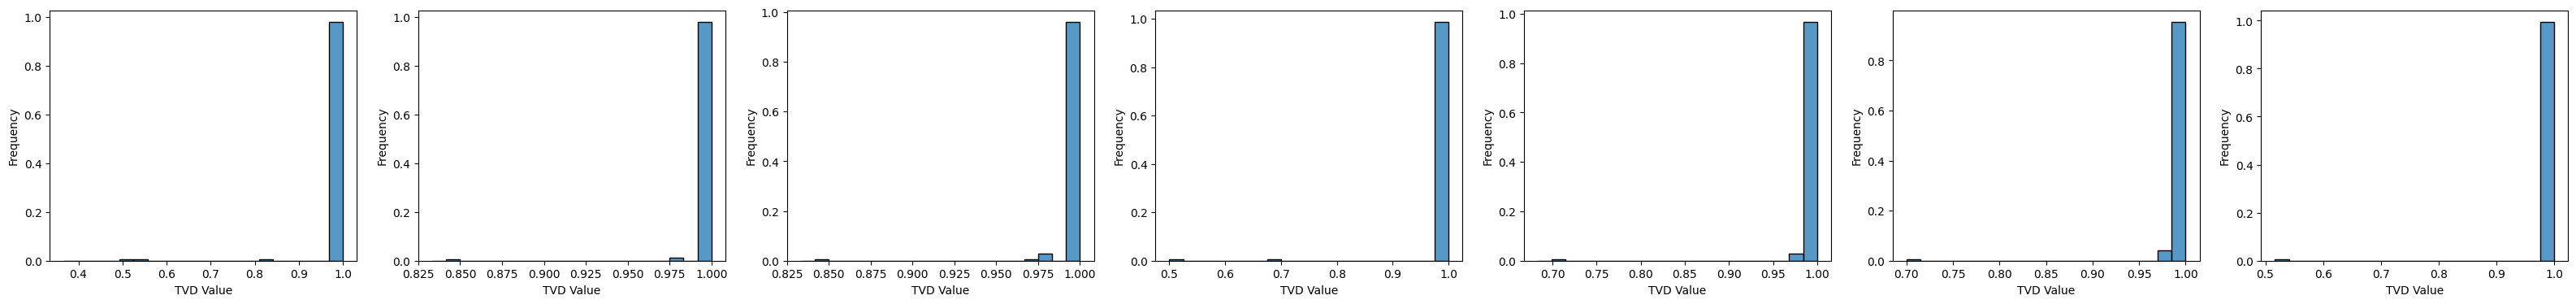

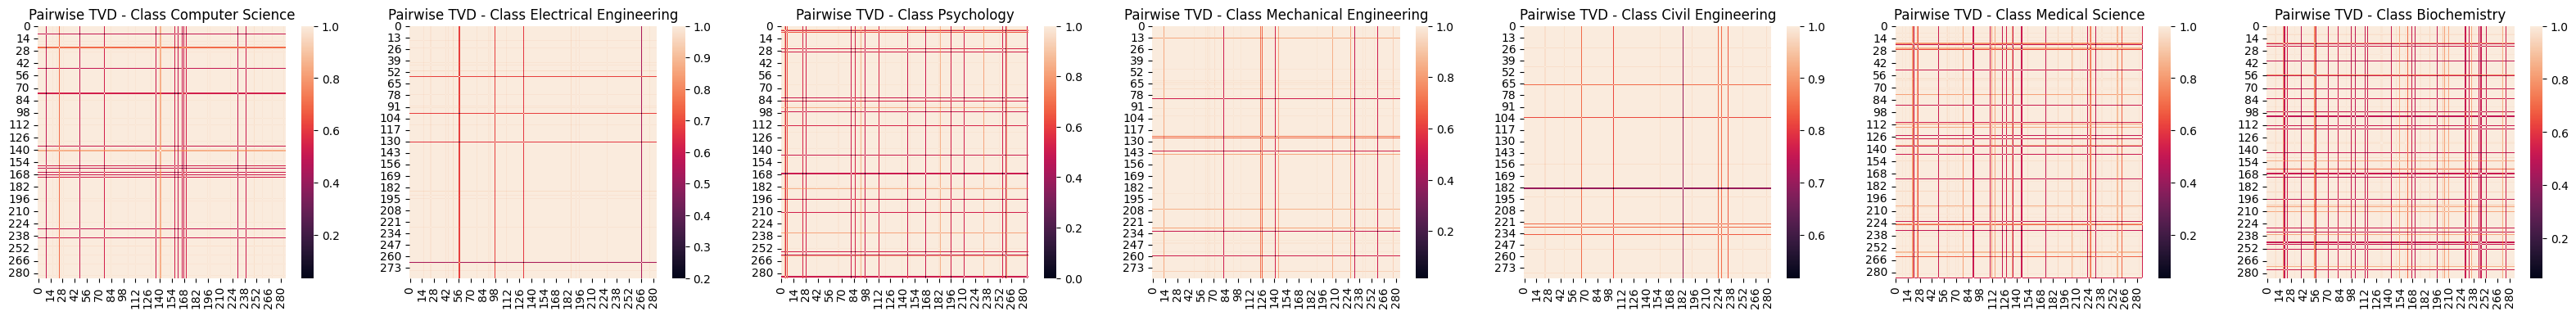

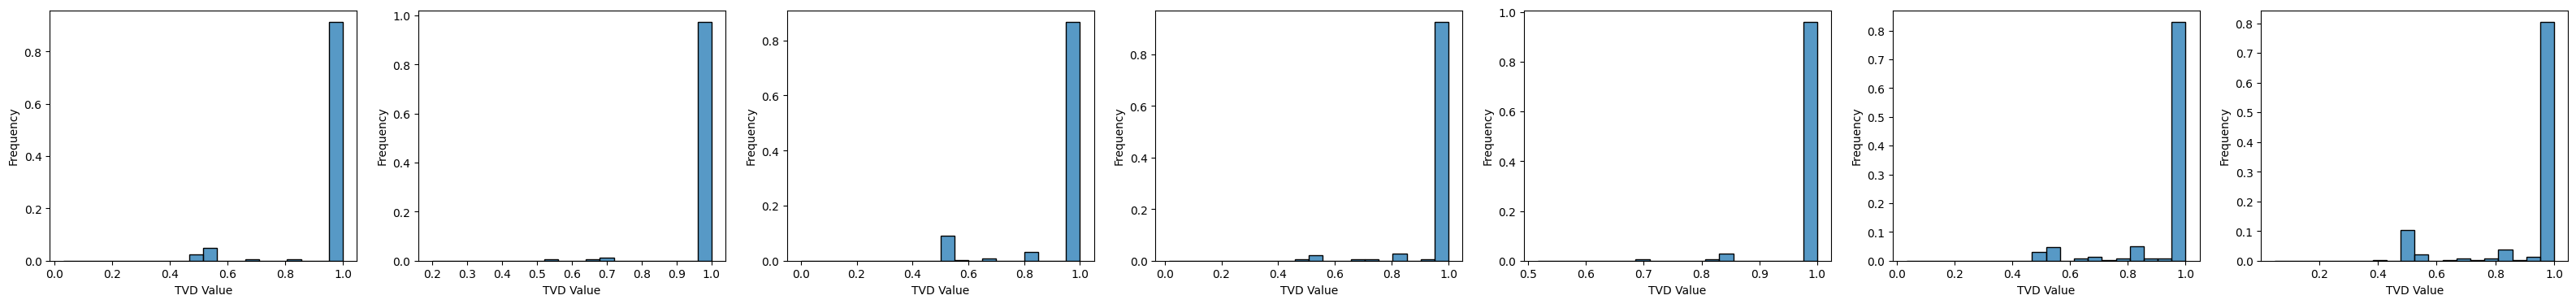

In [6]:
plot_TVD_info(sample_ids,
              prompt_types,
              llms,
              Qs,
              temp_questions,
              As,
              temp_answers,
              class_labels,
              results_folder)

Prompt type: simple


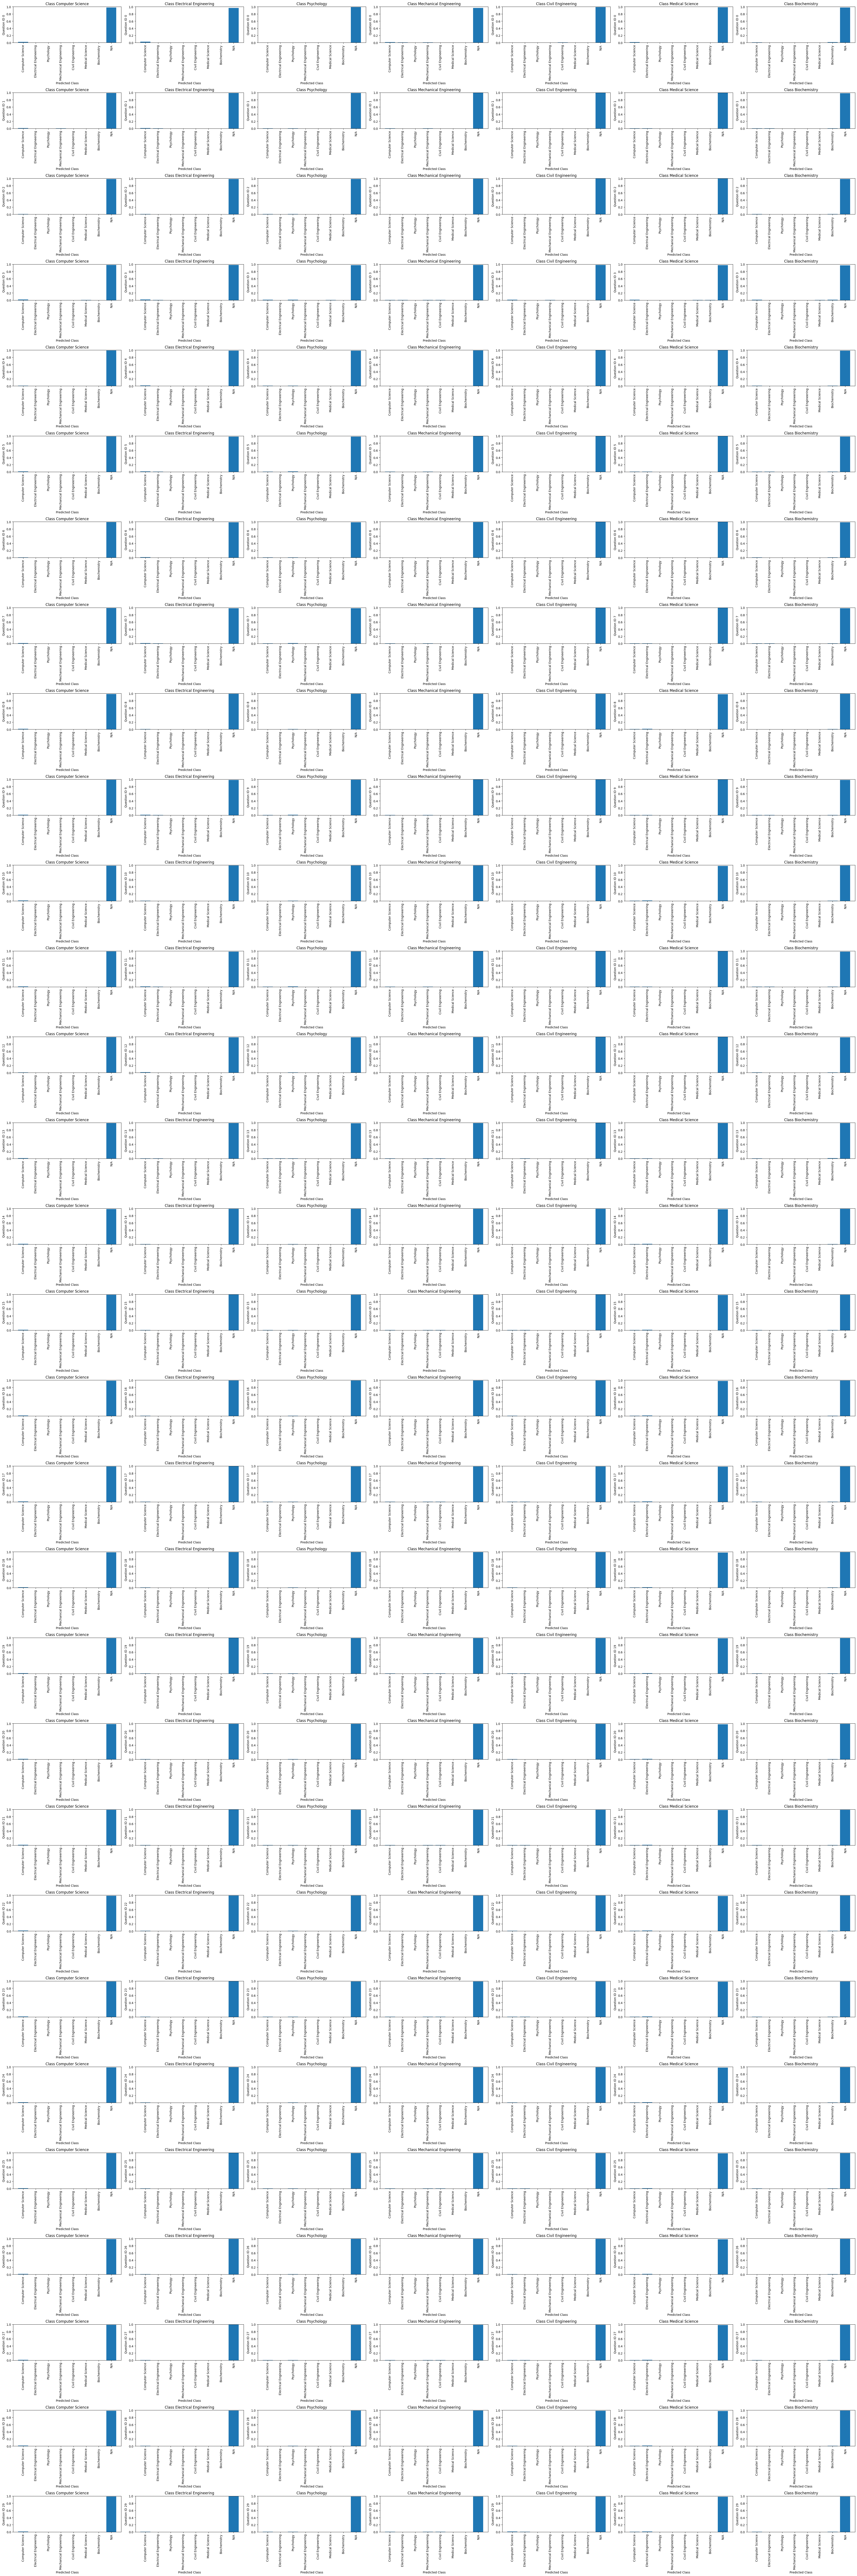

Prompt type: instruct


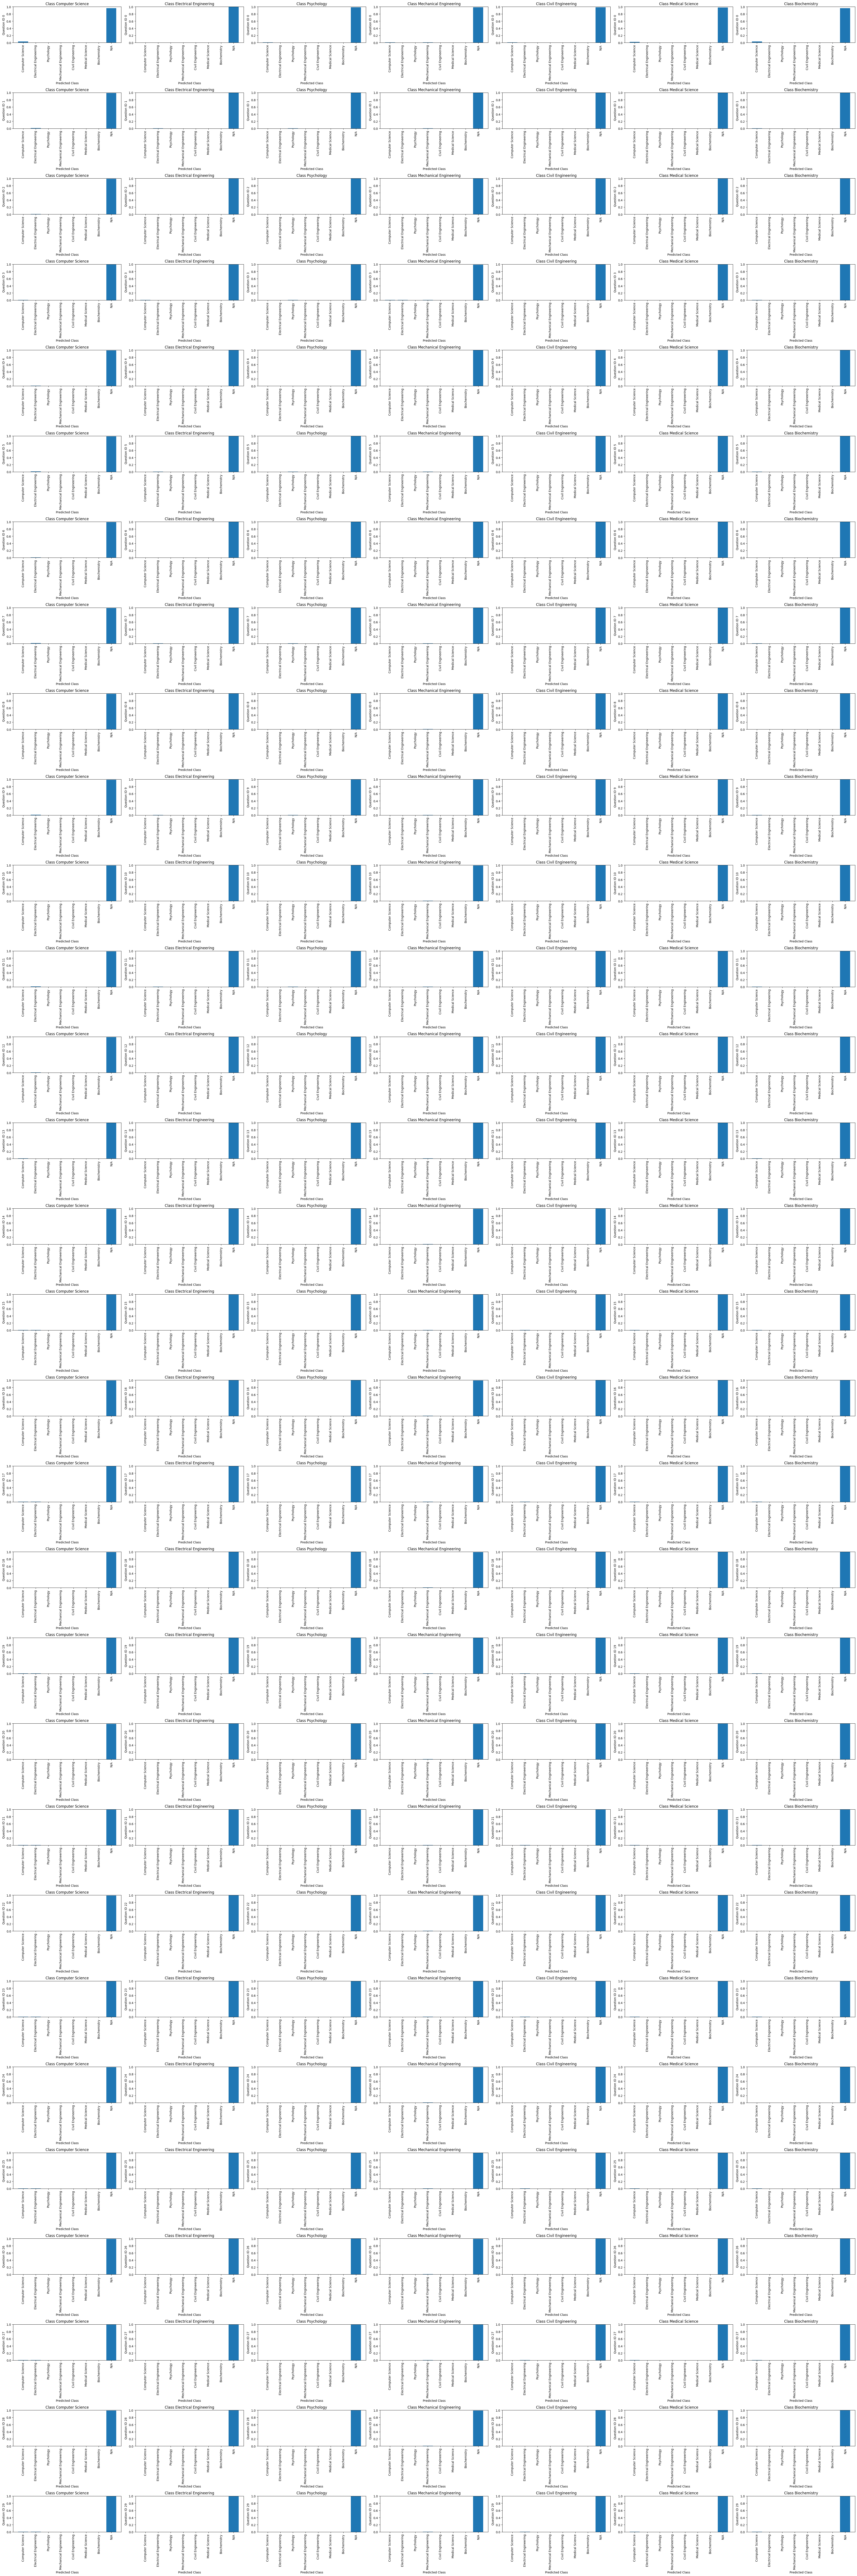

Prompt type: fewshot


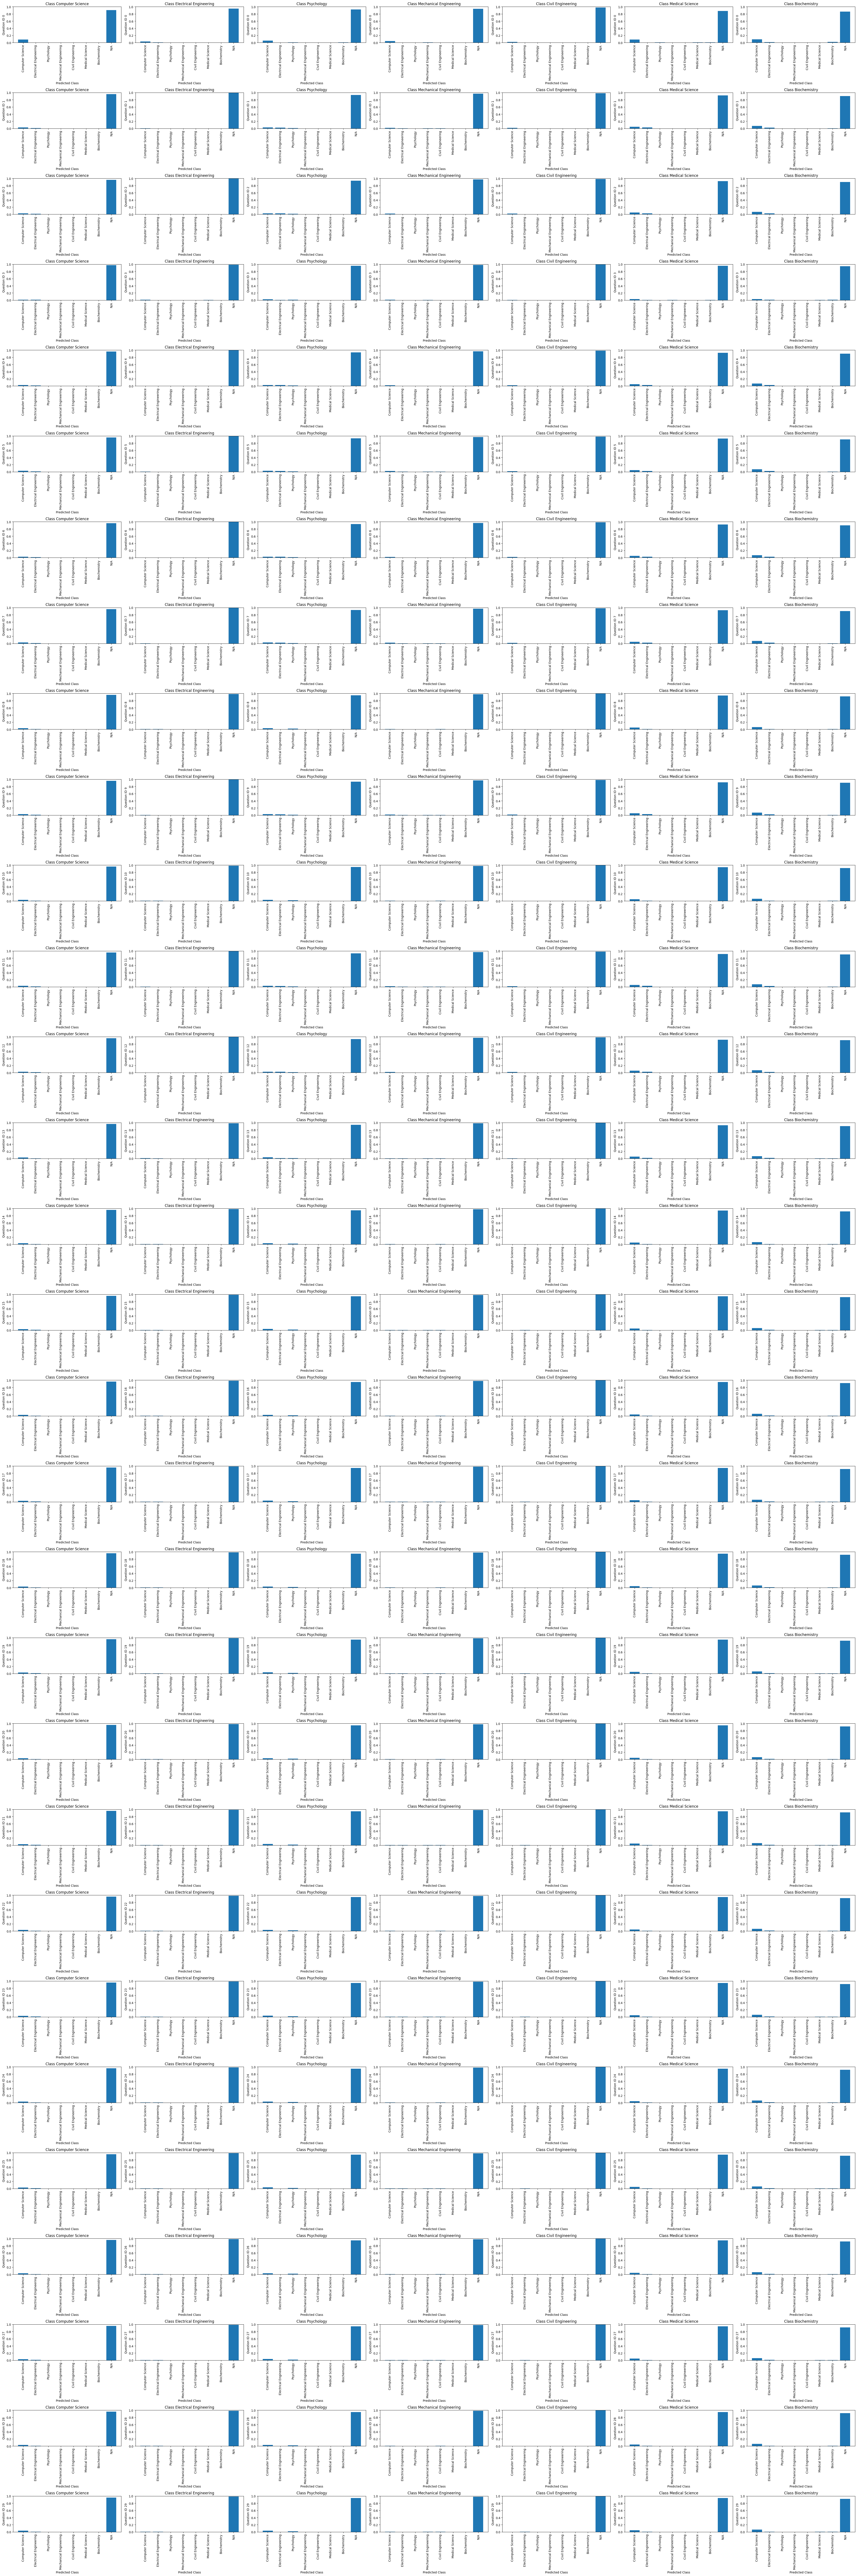

In [7]:
plot_questions_vs_predicted_distribution(sample_ids,
                                        prompt_types,
                                        llms,
                                        Qs,
                                        temp_questions,
                                        As,
                                        temp_answers,
                                        class_labels,
                                        results_folder)

Prompt type: simple


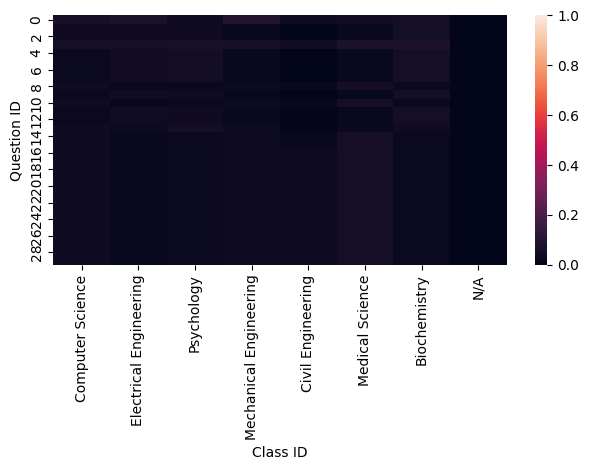

Prompt type: instruct


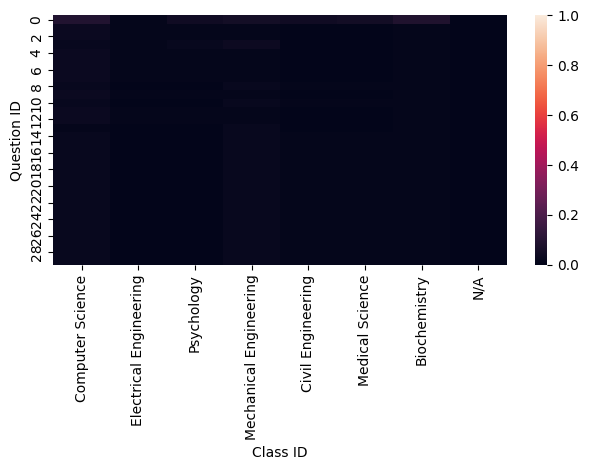

Prompt type: fewshot


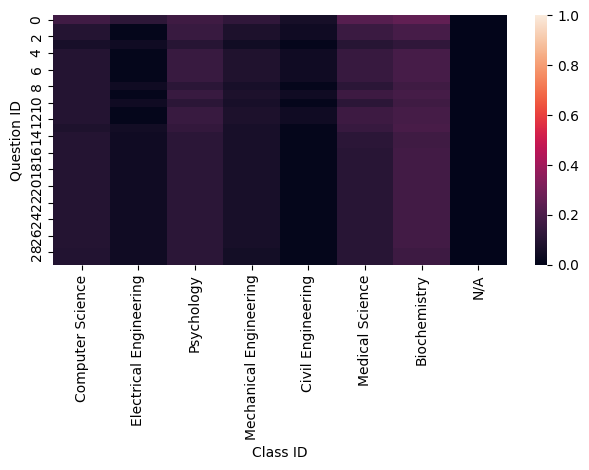

In [8]:
plot_questions_vs_class_sensitivity(sample_ids,
                               prompt_types,
                               llms,
                               Qs,
                               temp_questions,
                               As,
                               temp_answers,
                               class_labels,
                               results_folder)

In [9]:
for llm in ['llama-3.2-1b']:
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        Q = 30
        A = 1  # MUST stay 1
        temp_question = 0.
        temp_answer = 0.
        max_value = 1
        
        print_classification_scores(sample_ids,
                                    prompt_type,
                                    llm,
                                    Q,
                                    temp_question,
                                    A,
                                    temp_answer,
                                    class_labels,
                                    results_folder)

llama-3.2-1b simple
Global scores, accuracy: 0.0045, micro f1-score: 0.0045, macro f1-score: 0.007679681429681429
Standard deviation of microf1 score: 0.0008820745748266163
llama-3.2-1b instruct
Global scores, accuracy: 0.0015, micro f1-score: 0.0015, macro f1-score: 0.0026072121818598313
Standard deviation of microf1 score: 0.0009973576200251455
llama-3.2-1b fewshot
Global scores, accuracy: 0.01, micro f1-score: 0.01, macro f1-score: 0.015937828202514173
Standard deviation of microf1 score: 0.002471448068553243


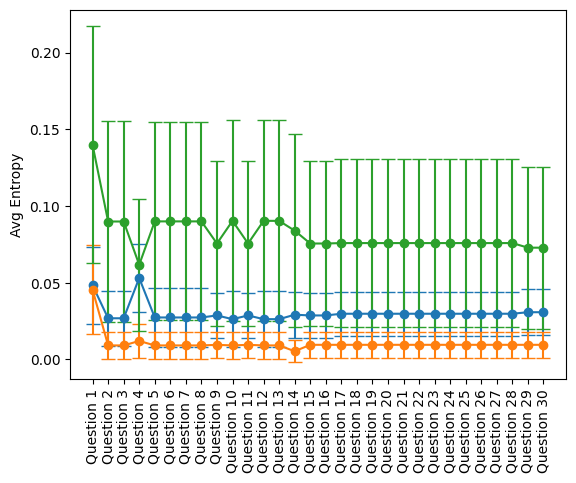

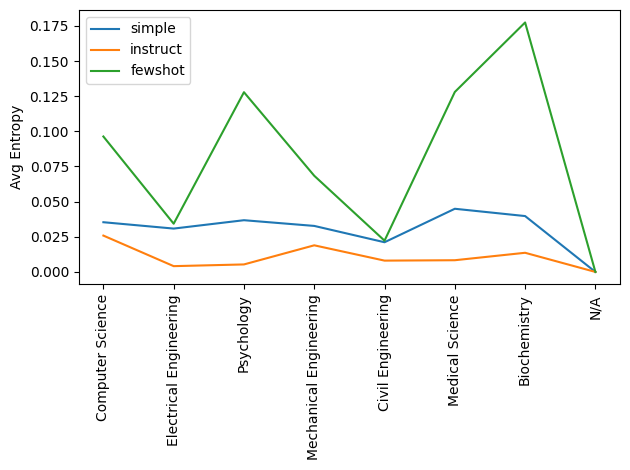

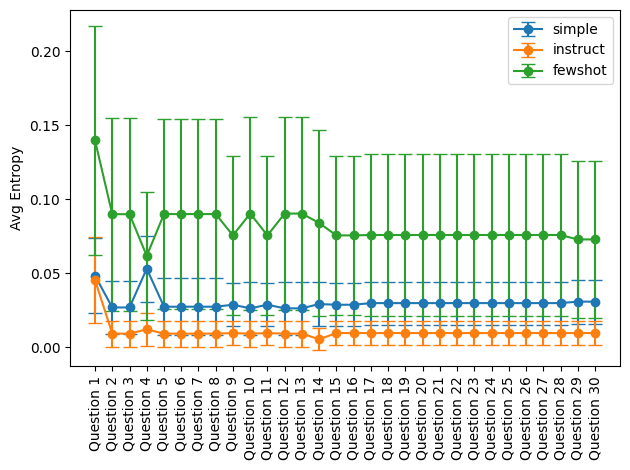

In [10]:
plot_avg_sensitivity(sample_ids,
                 prompt_types,
                 ['llama-3.2-1b'],
                 Qs,
                 [0.],
                 As,
                 temp_answers,
                 class_labels,
                 results_folder)

llama-3.2-1b simple
Avg Entropy over samples: 0.006016354855208835,Std over samples: 0.03582221273804847
llama-3.2-1b instruct
Avg Entropy over samples: 0.00292229327861914,Std over samples: 0.022270811521276995
llama-3.2-1b fewshot
Avg Entropy over samples: 0.016038569794777146,Std over samples: 0.06000058635850384


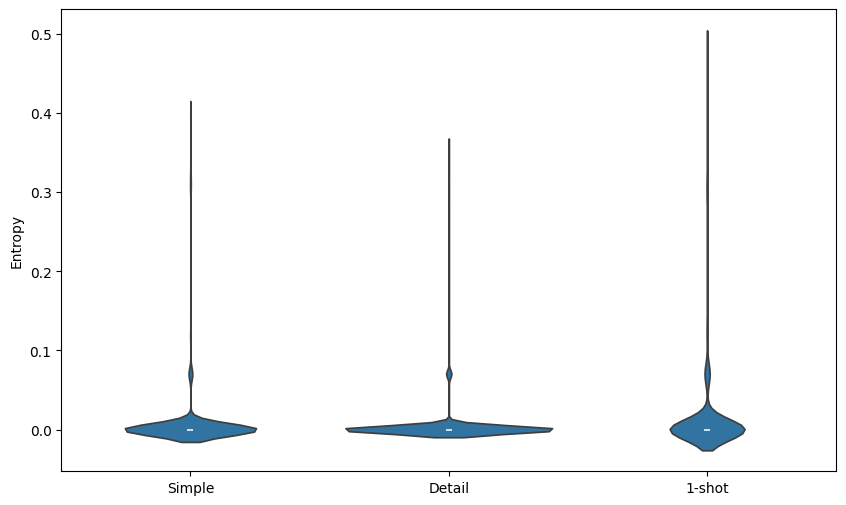

In [11]:
for llm in ['llama-3.2-1b']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []
    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)
    
        data.append((em, prompt_type))
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    ax =sns.violinplot(x='Label', y='Values', data=df, split=False)
    plt.xlabel(None)
    ax.set_xticks(np.arange(3)) # <--- set the ticks first
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.ylabel('Entropy')
    plt.show()

In [12]:
if not os.path.exists(Path(results_folder, 'paper_figures')):
    os.makedirs(Path(results_folder, 'paper_figures'))
    
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

dataset="WoS"

figsize=(7.5,4.5)
n_samples, n_classes = len(samples), len(class_labels)

for llm in ['llama-3.2-1b']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        TVD_matrix_per_class = print_consistency(sample_ids,
                                       prompt_type,
                                       llm,
                                       Q,
                                       temp_question,
                                       A,
                                       temp_answer,
                                       class_labels,
                                       results_folder)
    
        for c, TVD_matrix in enumerate(TVD_matrix_per_class):
            data.append((TVD_matrix.reshape(-1), prompt_type))
            
            c_name = class_labels[c]

            # plt.figure(figsize=(figsize[0]+1, figsize[0]))
            # ax = sns.heatmap(TVD_matrix, cbar_kws={'orientation': 'horizontal'})
            # plt.xlabel("Sample ID",fontsize=26)
            # plt.ylabel("Sample ID",fontsize=26)
            # # Adjust the layout to make room for the colorbar
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_matrix_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            # #plt.show()

            # sns.histplot(np.reshape(TVD_matrix, -1),
            #                         bins=20, stat='probability', kde=False, color='#3274A1', alpha=1.)
            # plt.xlabel(r"$C_y(x,x')$")
            # plt.tight_layout()
            # plt.savefig(Path(results_folder, 'paper_figures', f'TVD_hist_{dataset}_{prompt_type}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}_{c_name}.pdf'))
            # #plt.show()
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # # Plot the violin plot
    # plt.figure(figsize=figsize)  # Adjust the figure size if needed
    # ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    # plt.xlabel(None)
    # ax.set_xticks(np.arange(3)) # <--- set the ticks first
    # ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    # plt.ylim(0, 1)
    # plt.ylabel('Consistency')
    # plt.tight_layout()
    # plt.savefig(Path(results_folder, 'paper_figures',
    #         f'consistency_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    # plt.show()

llama-3.2-1b simple
Prompt type: simple
Avg consistency: 0.9759053279013655,Std consistency: 0.12923425017202209
llama-3.2-1b instruct
Prompt type: instruct
Avg consistency: 0.9919530816148435,Std consistency: 0.07054800704698831
llama-3.2-1b fewshot
Prompt type: fewshot
Avg consistency: 0.919736848245577,Std consistency: 0.24277654736912166


In [13]:
pip install Latex

Note: you may need to restart the kernel to use updated packages.


llama-3.2-1b simple
Avg Entropy over samples: 0.006016354855208835,Std over samples: 0.03582221273804847


C:\Users\Gareth\AppData\Local\Temp\ipykernel_13324\3192257179.py:54: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


llama-3.2-1b instruct
Avg Entropy over samples: 0.00292229327861914,Std over samples: 0.022270811521276995


C:\Users\Gareth\AppData\Local\Temp\ipykernel_13324\3192257179.py:54: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


llama-3.2-1b fewshot
Avg Entropy over samples: 0.016038569794777146,Std over samples: 0.06000058635850384


C:\Users\Gareth\AppData\Local\Temp\ipykernel_13324\3192257179.py:54: RuntimeWarning: Mean of empty slice.
  sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Gareth\anaconda3\envs\ollama1\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Gareth\AppData\Local\Temp\ipyker

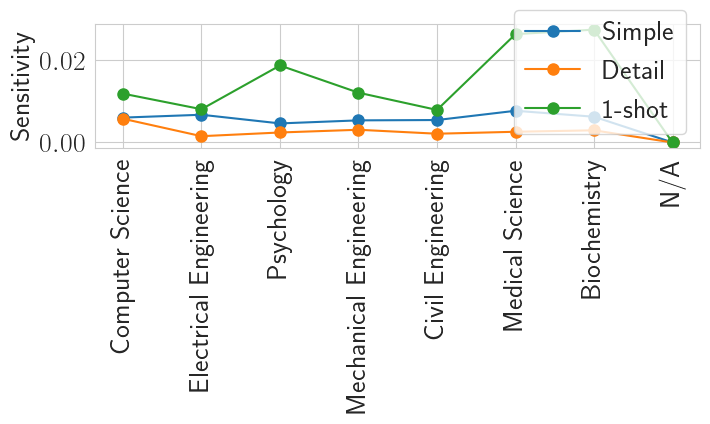

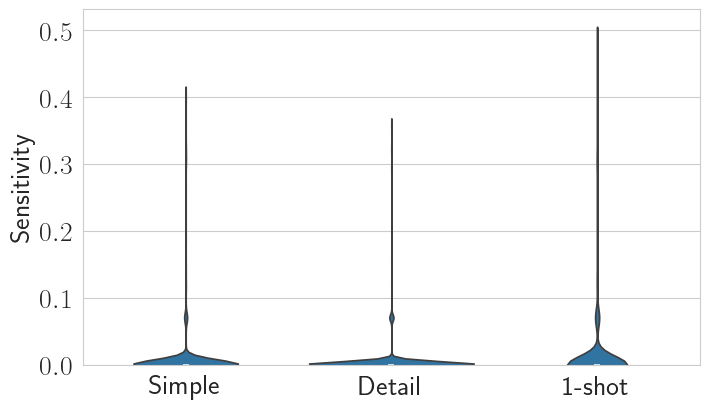

In [14]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

for llm in ['llama-3.2-1b']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    errorbar_fig = plt.figure(figsize=figsize)

    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder)

        sens_per_class = sensitivity_per_class(sample_ids,
                                               prompt_type,
                                               llm,
                                               Q,
                                               temp_question,
                                               A,
                                               temp_answer,
                                               class_labels,
                                               results_folder)

        # Add error bars (standard deviation)
        plt.figure(errorbar_fig)
        if prompt_type == 'instruct':
            label = 'Detail'
        elif prompt_type == 'fewshot':
            label = '1-shot'
        else:
            label = 'Simple'

        sens_per_class_mean = np.array([np.array(sens_per_class[c]).mean() for c in range(len(class_labels))])
        sens_per_class_mean = np.nan_to_num(sens_per_class_mean)
        sens_per_class_std = np.array([np.array(sens_per_class[c]).std() for c in range(len(class_labels))])
        sens_per_class_std = np.nan_to_num(sens_per_class_std)
        # plt.errorbar(np.arange(len(class_labels)), sens_per_class_mean, yerr=sens_per_class_std, fmt='-o',  solid_capstyle='projecting', capsize=5, label=label)
        plt.plot(sens_per_class_mean, label=label, marker='o', markersize=8)
        plt.ylabel('Sensitivity')
        plt.xticks(np.arange(len(class_labels)),
                            class_labels,
                            rotation='vertical')      
        plt.legend()
        
        data.append((em, prompt_type))

        plt.figure(errorbar_fig)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_class_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    
    
    # Prepare lists to collect expanded data
    expanded_values = []
    expanded_labels = []
    
    # Expand the data into individual points
    for arr, label in data:
        expanded_values.extend(arr)
        expanded_labels.extend([label] * len(arr))
    
    # Create a DataFrame from the expanded data
    df = pd.DataFrame({'Values': expanded_values, 'Label': expanded_labels})
    
    # Plot the violin plot
    plt.figure(figsize=figsize)  # Adjust the figure size if needed
    ax = sns.violinplot(x='Label', y='Values', data=df, split=False)
    ax.set_xticklabels(['Simple', 'Detail', '1-shot'])
    plt.xlabel(None)
    plt.ylabel('Sensitivity')
    # Setting the y-axis limits to cut off values below 0
    plt.ylim(0, None)
    plt.tight_layout()
    plt.savefig(Path(results_folder, 'paper_figures',
                f'sensitivity_vs_prompting_{dataset}_{llm}_{Q}_{A}_{temp_question}_{temp_answer}.pdf'))
    plt.show()

Avg Entropy over samples: 0.006016354855208835,Std over samples: 0.03582221273804847
Avg Entropy over samples: 0.00292229327861914,Std over samples: 0.022270811521276995
Avg Entropy over samples: 0.016038569794777146,Std over samples: 0.06000058635850384
   Sensitivity Strategy           LLM  Temperature
0     0.006016   Simple  llama-3.2-1b            0
1     0.002922   Detail  llama-3.2-1b            0
2     0.016039   1-shot  llama-3.2-1b            0


<Figure size 750x450 with 0 Axes>

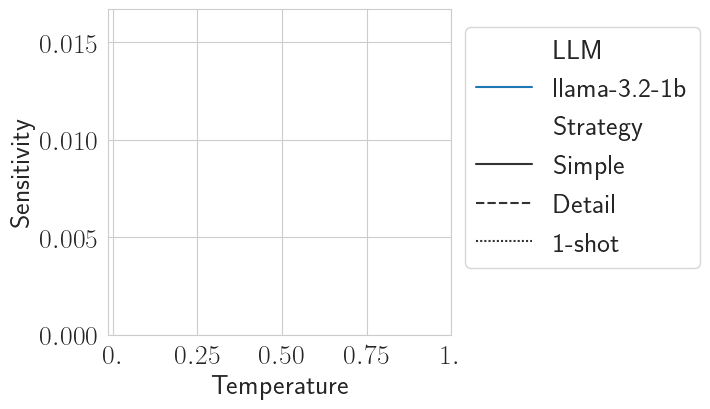

In [15]:
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

figsize=(7.5,4.5)

Q = 30
A = 1  # MUST stay 1
temp_answer = 0.


data = []
errorbar_fig = plt.figure(figsize=figsize)
    
for temp_question in temp_questions:
    
    for llm in ['llama-3.2-1b']:
        
        for prompt_type in ['simple', 'instruct', 'fewshot']:
            
            em = print_test_sensitivity_over_samples(sample_ids,
                                            prompt_type,
                                            llm,
                                            Q,
                                            temp_question,
                                            A,
                                            temp_answer,
                                            class_labels,
                                            results_folder)
    
    
            # Add error bars (standard deviation)
            plt.figure(errorbar_fig)
            if prompt_type == 'instruct':
                label = 'Detail'
            elif prompt_type == 'fewshot':
                label = '1-shot'
            else:
                label = 'Simple'
    
            
            data.append((em.mean(), label, llm, int(temp_question/0.25)))
            
        
        
# Create a DataFrame from the expanded data
df = pd.DataFrame(data, columns=['Sensitivity', 'Strategy', 'LLM', 'Temperature'])
print(df)
# Plot the violin plot
plt.figure(figsize=figsize)  # Adjust the figure size if needed
ax = sns.lineplot(x='Temperature', y='Sensitivity', hue='LLM', style='Strategy', data=df)
ax.set_xticks(np.arange(5)) # <--- set the ticks first
ax.set_xticklabels([r'$0.$', r'$0.25$', r'$0.50$', r'$0.75$', r'$1.$'])
# Setting the y-axis limits to cut off values below 0
plt.ylim(0, None)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.575))
plt.tight_layout()
plt.savefig(Path(results_folder, 'paper_figures',
            f'sensitivity_vs_temperature_{dataset}_{Q}_{A}_{temp_answer}.pdf'))
plt.show()

In [16]:
for llm in ['llama-3.2-1b']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        em = print_test_sensitivity_over_samples(sample_ids,
                                        prompt_type,
                                        llm,
                                        Q,
                                        temp_question,
                                        A,
                                        temp_answer,
                                        class_labels,
                                        results_folder,
                                        noise_amount=1.)


llama-3.2-1b simple
Avg Entropy over samples: 0.9397477314375299,Std over samples: 0.03230921537422844
llama-3.2-1b instruct
Avg Entropy over samples: 0.9391824844672976,Std over samples: 0.0329484021016627
llama-3.2-1b fewshot
Avg Entropy over samples: 0.9396178984391127,Std over samples: 0.03273253633547304


In [17]:
if not os.path.exists(Path(results_folder, 'paper_figures')):
    os.makedirs(Path(results_folder, 'paper_figures'))
    
# Configure matplotlib to use LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Set the global font size
plt.rc('font', size=20)  # Example: set the font size to 14

sns.set_style("whitegrid")
sns.color_palette("colorblind")

dataset="WOS46985"
figsize=(7.5,4.5)
n_samples, n_classes = len(samples), len(class_labels)

for llm in ['llama-3.2-1b']:
    Q = 30
    A = 1  # MUST stay 1
    temp_question = 0.
    temp_answer = 0.
    
    data = []

    for prompt_type in ['simple', 'instruct', 'fewshot']:
        print(llm, prompt_type)
        TVD_matrix_per_class = print_consistency(sample_ids,
                                       prompt_type,
                                       llm,
                                       Q,
                                       temp_question,
                                       A,
                                       temp_answer,
                                       class_labels,
                                       results_folder,
                                       noise_amount=1.)

llama-3.2-1b simple
Prompt type: simple
0.8679237104272747
0.9451972486759771
0.9036934987480928
0.9608629101672779
0.9630821428363862
0.9524752712543504
0.9885320767858675
0.979034821538386
0.9215783929085017
0.9352350603177576
0.9698952323040214
0.979857420662241
0.9579222156507178
0.9383536707343567
0.9524752712543504
0.9238762384142848
0.9830851323895001
0.9324722817012364
0.9297881159213902
0.9141224544300894
0.9790348215383857
0.9484249604032362
0.9202908606739086
0.9064562773646138
0.965844921452907
0.9692505490802052
0.9447323155652391
0.9343033598832423
0.9175280820573875
0.9524752712543504
0.8574179761216424
0.9297881159213902
0.9356999934284955
0.9692505490802052
0.966309854563645
0.9520103381436124
0.9159535326120953
0.9073093649624542
0.8937313103898732
0.8676366932165758
0.946563393747245
0.8919002322078672
0.9347701272070196
0.9024059665134995
0.8996431878969785
0.9703601654147594
0.943622699230685
0.9356999934284954
0.8719740212783889
0.8740153380474582
0.89419624350061